In [0]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import least_squares

In [0]:
torch.cuda.is_available()

False

In [0]:
# Constants
GAMMA = 0.99

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        #print('x after softmax = {}'.format(x))
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #print('probs = {}'.format(probs))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [0]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ValueNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, 1)
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = self.linear1(state)
        value = F.relu(self.linear1(state))
        value = self.linear2(value)
        return value

In [0]:
def update_policy(policy_network, trajectories_gradient):
    policy_network.optimizer.zero_grad()    
    policy_gradient = torch.stack(trajectories_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [0]:
def count_trajectory_for_baseline(rewards, log_probs, baseline):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    log_deriv = []
    for log_prob in log_probs:
      if log_prob != 0:
        log_prob.backward(retain_graph = True)
        deriv = []
        for param in policy_net.parameters():
          deriv.append(param.grad.resize(param.grad.numel()))
        deriv = torch.cat([tensor**2 for tensor in deriv], 0)
        log_deriv.append(deriv.sum())
      else:
        log_deriv.append(0)

    for log_prob_deriv, Gt, bs in zip(log_deriv, discounted_rewards, baseline):
        if log_prob_deriv == 0:
            policy_gradient.append(torch.tensor([0.0], requires_grad = True))
        else:
            term = bs.resize(1)
            term = term - Gt
            term = term**2
            term = term * log_prob_deriv.detach()
            #policy_gradient.append(torch.tensor([log_prob_deriv * (Gt - bs.resize(1))**2], requires_grad = True))
            policy_gradient.append(term)
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [0]:
def count_trajectory_for_policy(rewards, log_probs, baseline):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt, bs in zip(log_probs, discounted_rewards, baseline):
        if log_prob == 0:
            policy_gradient.append(torch.tensor([[0.0]], requires_grad = True))
        else:
            policy_gradient.append(-log_prob * (Gt - bs))
    
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [0]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [0]:
def baseline_approximation(policy_net, value_net, n_trajectories, n_epoch = 4000, early_stopping_rounds = 250):
    max_steps = 10000
    min_loss = float('inf')
    stopping_rounds = 0
    epoch = 1
    value_loss_list = []
    
    rewards = [[] for i in range(n_trajectories)]
    log_probs = [[] for i in range(n_trajectories)]

    states = [[] for i in range(n_trajectories)]
    
    for trajectory in range(n_trajectories):
        state = env.reset()
            
        for steps in range(max_steps):
            states[trajectory].append(state)
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(np.array(action))
            log_probs[trajectory].append(log_prob)
            rewards[trajectory].append(reward)
            if done:                    
                break
            state = new_state

    rewards = align_columns_zeros(rewards)
    log_probs = align_columns_zeros(log_probs)

    while(stopping_rounds < early_stopping_rounds and epoch < n_epoch):
      r_gradient = []
      baseline_values = [[] for i in range(n_trajectories)]

      for trajectory in range(n_trajectories):
        for state_element in states[trajectory]:
          baseline = value_net.forward(state)
          baseline_values[trajectory].append(baseline)
      baseline_values = align_columns_zeros(baseline_values)
      #print(np.array(baseline_values).shape)
      for col in range(len(rewards)):
          traj = count_trajectory_for_baseline(rewards[col], log_probs[col], baseline_values[col])
          r_gradient.append(traj)

      r_gradient = torch.stack(r_gradient)
      value_loss = r_gradient.mean()
      value_loss_list.append(value_loss)
      if value_loss < min_loss:
          min_loss = value_loss
          torch.save(value_net, 'model.pth')
          print('{}. Current minimum value loss = {}'.format(epoch, value_loss))
          stopping_rounds += 1
      else:
          stopping_rounds = 0
      #print('{}. Current value loss = {}, min value_loss = {}, stopping_round = {}'.format(epoch, value_loss, min_loss, stopping_rounds))
      epoch += 1
      value_net.optimizer.zero_grad()
      value_loss.backward()
      value_net.optimizer.step()
    value_net = torch.load('model.pth')
    return value_loss_list

In [0]:
def cart_pole_baseline(value_net, n_trajectories = 2, episode_num = 1500, baseline_retrain = False, retrain_episodes = 50):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
    

    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]

    for episode in range(1, max_episode_num + 1):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        baseline_values = []
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            
            for steps in range(max_steps):
                #env.render()
                baseline = value_net.forward(state)
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                baseline_values.append(baseline)
                
                if done:
                    traj = count_trajectory_for_policy(rewards[trajectory], log_probs, baseline_values)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state
                
        update_policy(policy_net, r_gradient)                 
        rewards = align_columns_zeros(rewards)
        #print(all_rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average_reward_among_trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
            
        if baseline_retrain == True:
            if episode % retrain_episodes == 0:
                baseline_approximation(policy_net, value_net, 3, n_epoch = 1000, early_stopping_rounds=10)
        
    return all_rewards, avg_numsteps

In [0]:
%%time
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
value_net = ValueNetwork(env.observation_space.shape[0], env.action_space.n, 256)
lst_loss = baseline_approximation(policy_net, value_net, 100, early_stopping_rounds=100)

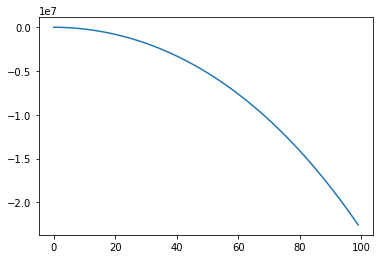

In [0]:
plt.plot(range(len(lst_loss)), lst_loss)

In [0]:
%%time
statistics_all = []
statistics_mean = []
for game in tqdm(range(10)):
  all_rewards, mean_rewards = cart_pole_baseline(value_net, 1, 2000)
  statistics_all.append(all_rewards)
  statistics_mean.append(mean_rewards)

  0%|          | 0/10 [00:00<?, ?it/s]

episode: 10, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 18.4
episode: 20, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 17.9
episode: 30, total mean reward among trajectories: 26.0, average_reward_among_trajectories: 15.2
episode: 40, total mean reward among trajectories: 11.0, average_reward_among_trajectories: 18.0
episode: 50, total mean reward among trajectories: 11.0, average_reward_among_trajectories: 18.9
episode: 60, total mean reward among trajectories: 21.0, average_reward_among_trajectories: 21.1
episode: 70, total mean reward among trajectories: 12.0, average_reward_among_trajectories: 19.5
episode: 80, total mean reward among trajectories: 16.0, average_reward_among_trajectories: 22.6
episode: 90, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 21.7
episode: 100, total mean reward among trajectories: 36.0, average_reward_among_trajectories: 25.5
episode: 110, total mean rewa

 10%|█         | 1/10 [02:17<20:35, 137.26s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 197.9
episode: 10, total mean reward among trajectories: 21.0, average_reward_among_trajectories: 24.3
episode: 20, total mean reward among trajectories: 29.0, average_reward_among_trajectories: 27.7
episode: 30, total mean reward among trajectories: 44.0, average_reward_among_trajectories: 26.7
episode: 40, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 30.7
episode: 50, total mean reward among trajectories: 21.0, average_reward_among_trajectories: 23.9
episode: 60, total mean reward among trajectories: 33.0, average_reward_among_trajectories: 27.2
episode: 70, total mean reward among trajectories: 47.0, average_reward_among_trajectories: 31.0
episode: 80, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 26.4
episode: 90, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 25.4
episode: 100, total mean r

 20%|██        | 2/10 [04:30<18:07, 135.99s/it]

episode: 2000, total mean reward among trajectories: 147.0, average_reward_among_trajectories: 169.4
episode: 10, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 19.0
episode: 20, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 19.1
episode: 30, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 20.3
episode: 40, total mean reward among trajectories: 24.0, average_reward_among_trajectories: 20.0
episode: 50, total mean reward among trajectories: 35.0, average_reward_among_trajectories: 28.7
episode: 60, total mean reward among trajectories: 12.0, average_reward_among_trajectories: 24.6
episode: 70, total mean reward among trajectories: 14.0, average_reward_among_trajectories: 28.0
episode: 80, total mean reward among trajectories: 20.0, average_reward_among_trajectories: 27.1
episode: 90, total mean reward among trajectories: 51.0, average_reward_among_trajectories: 28.5
episode: 100, total mean r

 30%|███       | 3/10 [06:42<15:44, 134.86s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 189.4
episode: 10, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 18.0
episode: 20, total mean reward among trajectories: 11.0, average_reward_among_trajectories: 20.9
episode: 30, total mean reward among trajectories: 35.0, average_reward_among_trajectories: 28.1
episode: 40, total mean reward among trajectories: 24.0, average_reward_among_trajectories: 21.9
episode: 50, total mean reward among trajectories: 31.0, average_reward_among_trajectories: 23.3
episode: 60, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 19.5
episode: 70, total mean reward among trajectories: 23.0, average_reward_among_trajectories: 22.3
episode: 80, total mean reward among trajectories: 20.0, average_reward_among_trajectories: 19.1
episode: 90, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 26.9
episode: 100, total mean r

 40%|████      | 4/10 [08:59<13:33, 135.59s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 200.0
episode: 10, total mean reward among trajectories: 40.0, average_reward_among_trajectories: 22.2
episode: 20, total mean reward among trajectories: 48.0, average_reward_among_trajectories: 20.3
episode: 30, total mean reward among trajectories: 55.0, average_reward_among_trajectories: 26.9
episode: 40, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 29.1
episode: 50, total mean reward among trajectories: 52.0, average_reward_among_trajectories: 25.9
episode: 60, total mean reward among trajectories: 22.0, average_reward_among_trajectories: 23.3
episode: 70, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 33.5
episode: 80, total mean reward among trajectories: 10.0, average_reward_among_trajectories: 25.4
episode: 90, total mean reward among trajectories: 43.0, average_reward_among_trajectories: 22.5
episode: 100, total mean r

 50%|█████     | 5/10 [10:59<10:54, 130.86s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 188.3
episode: 10, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 20.0
episode: 20, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 20.2
episode: 30, total mean reward among trajectories: 12.0, average_reward_among_trajectories: 18.4
episode: 40, total mean reward among trajectories: 24.0, average_reward_among_trajectories: 24.0
episode: 50, total mean reward among trajectories: 31.0, average_reward_among_trajectories: 24.9
episode: 60, total mean reward among trajectories: 52.0, average_reward_among_trajectories: 26.4
episode: 70, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 27.7
episode: 80, total mean reward among trajectories: 32.0, average_reward_among_trajectories: 19.6
episode: 90, total mean reward among trajectories: 23.0, average_reward_among_trajectories: 25.2
episode: 100, total mean r

 60%|██████    | 6/10 [13:14<08:48, 132.06s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.4
episode: 10, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 24.4
episode: 20, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 23.2
episode: 30, total mean reward among trajectories: 47.0, average_reward_among_trajectories: 24.9
episode: 40, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 22.1
episode: 50, total mean reward among trajectories: 30.0, average_reward_among_trajectories: 35.8
episode: 60, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 39.9
episode: 70, total mean reward among trajectories: 33.0, average_reward_among_trajectories: 39.2
episode: 80, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 33.7
episode: 90, total mean reward among trajectories: 46.0, average_reward_among_trajectories: 27.7
episode: 100, total mean r

 70%|███████   | 7/10 [15:16<06:26, 128.94s/it]

episode: 2000, total mean reward among trajectories: 138.0, average_reward_among_trajectories: 192.3
episode: 10, total mean reward among trajectories: 33.0, average_reward_among_trajectories: 23.7
episode: 20, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 23.7
episode: 30, total mean reward among trajectories: 33.0, average_reward_among_trajectories: 29.5
episode: 40, total mean reward among trajectories: 45.0, average_reward_among_trajectories: 25.9
episode: 50, total mean reward among trajectories: 35.0, average_reward_among_trajectories: 28.6
episode: 60, total mean reward among trajectories: 20.0, average_reward_among_trajectories: 28.9
episode: 70, total mean reward among trajectories: 40.0, average_reward_among_trajectories: 25.9
episode: 80, total mean reward among trajectories: 45.0, average_reward_among_trajectories: 24.6
episode: 90, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 26.2
episode: 100, total mean r

 80%|████████  | 8/10 [17:29<04:20, 130.20s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 200.0
episode: 10, total mean reward among trajectories: 10.0, average_reward_among_trajectories: 19.7
episode: 20, total mean reward among trajectories: 80.0, average_reward_among_trajectories: 25.8
episode: 30, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 19.5
episode: 40, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 18.8
episode: 50, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 19.6
episode: 60, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 22.8
episode: 70, total mean reward among trajectories: 15.0, average_reward_among_trajectories: 22.3
episode: 80, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 24.2
episode: 90, total mean reward among trajectories: 22.0, average_reward_among_trajectories: 25.7
episode: 100, total mean r

 90%|█████████ | 9/10 [19:40<02:10, 130.47s/it]

episode: 2000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 189.6
episode: 10, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 17.4
episode: 20, total mean reward among trajectories: 50.0, average_reward_among_trajectories: 25.8
episode: 30, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 20.0
episode: 40, total mean reward among trajectories: 22.0, average_reward_among_trajectories: 26.8
episode: 50, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 19.4
episode: 60, total mean reward among trajectories: 24.0, average_reward_among_trajectories: 26.8
episode: 70, total mean reward among trajectories: 28.0, average_reward_among_trajectories: 32.1
episode: 80, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 22.6
episode: 90, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 21.3
episode: 100, total mean r

100%|██████████| 10/10 [21:49<00:00, 130.93s/it]

episode: 2000, total mean reward among trajectories: 142.0, average_reward_among_trajectories: 188.8
CPU times: user 21min 33s, sys: 9.75 s, total: 21min 42s
Wall time: 21min 49s


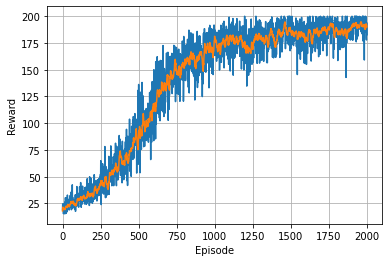

Varince of reward = 3455.63969039


In [0]:
plt.plot(np.mean(np.mean(statistics_all, axis = 1), axis = 0))
plt.plot(np.mean(np.mean(statistics_mean, axis = 1), axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(np.mean(statistics_all, axis = 1), axis = 0))))